#### DSC 530 Exploratory Data Analysis
#### Zach Barnhart
#### Final Project

We will analyze a dataset of housing data to find which variables have a strong relationship with SalePrice. The Ames housing data is a dataset consisting of 81 features (80 if you exclude the ID column used as a primary key), covering most measurable aspects of each house - sale price, total living area, total lot size, neighborhood, year built, year remodelled, number of bathrooms, size of garage, etc. It can be found on Kaggle here: https://www.kaggle.com/datasets/shashanknecrothapa/ames-housing-dataset

In [1]:
import pandas as pd
import numpy as np
import patsy
import random
import matplotlib.pyplot as plt
import thinkplot
import thinkstats2
import hypothesis
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy.stats import shapiro
from scipy.stats import ttest_ind
from math import log

In [2]:
housing = pd.read_csv("train.csv")

In [3]:
housing.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In order to build any kind of coherent model using this data, we need to encode certain features properly. Let us look at the data description file:

In [4]:
data_description = open('data_description.txt', 'r')
while True:
    line = data_description.readline()
    if not line:
        break
    print(line, end="")
data_description.close()

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM

A priori, we can't be sure which variables will definitively have an impact on sale price, but we can take a guess. Here, we will look at variables related to size of the house and quality - overall quality (OverallQual: Rates the overall material and finish of the house), ground living area (GrLivArea: Above grade (ground) living area square feet), external quality (ExterQual: Evaluates the quality of the material on the exterior), kitchen quality (KitchenQual), size of garage in car capacity (GarageCars), Size of garage in square feet (GarageArea), total square feet of basement area (TotalBsmtSF), year built (YearBuilt), basement quality (BsmtQual: Evaluates the height of the basement), and number of full bathrooms (FullBath).

Let's see where we have missing values, if any. If we decide to use any features with missing values in our analysis, we will have to impute them.

In [5]:
housingNA = housing.isnull().sum().sort_values(ascending=False)
housingNA[housingNA!=0]

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageCond        81
GarageType        81
GarageFinish      81
GarageQual        81
BsmtFinType2      38
BsmtExposure      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
dtype: int64

The features related to quality might be nice to use in a model, but they are encoded in a manner than belies their ordinal nature:

ExterQual: Evaluates the quality of the material on the exterior 
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor

BsmtQual: Evaluates the height of the basement

       Ex	Excellent (100+ inches)	
       Gd	Good (90-99 inches)
       TA	Typical (80-89 inches)
       Fa	Fair (70-79 inches)
       Po	Poor (<70 inches
       NA	No Basement

KitchenQual: Kitchen quality

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor

We will need to re-encode these in an ordinal scale in order to use them in a model. First we need to replace the NAs in BsmtQual with the designated string for such purposes.

In [6]:
housing.loc[housing.BsmtQual.isna(), "BsmtQual"] = "NA"

Now we re-encode

In [7]:
qualEncoding = {
    "NA":0,
    "Po":1,
    "Fa":2,
    "TA":3,
    "Gd":4,
    "Ex":5
}

In [8]:
housing.BsmtQual = housing.BsmtQual.map(qualEncoding)
housing.ExterQual = housing.ExterQual.map(qualEncoding)
housing.KitchenQual = housing.KitchenQual.map(qualEncoding)

Ok, now that the quality variables have been properly encoded, let us look at the histogram of each variable

In [9]:
columns = ["SalePrice", "OverallQual", "GrLivArea", "ExterQual", "KitchenQual", "GarageCars", "GarageArea", "TotalBsmtSF", "YearBuilt", "BsmtQual", "FullBath"]
units = {
    "SalePrice":"Sale price in dollars",
    "OverallQual":"Overall Quality Rating",
    "ExterQual":"External Quality Rating",
    "KitchenQual":"Kitchen Quality",
    "GarageCars":"Car Capacity of Garage",
    "GarageArea":"Garage Area in Square Ft",
    "TotalBsmtSF":"Size of Basement in Square Ft",
    "YearBuilt":"Year Built",
    "BsmtQual":"Height Classification of Basement",
    "FullBath":"Number of Full Bathrooms" ,
    "GrLivArea":"Total Above Ground Living Area (Sq ft)"
}

# After plotting the histograms a first time, I came back to add this to make the plots better
numbins = {
    "SalePrice":20,
    "OverallQual":10,
    "ExterQual":4,
    "KitchenQual":4,
    "GarageCars":5,
    "GarageArea":15,
    "TotalBsmtSF":15,
    "YearBuilt":20,
    "BsmtQual":6,
    "FullBath":4,
    "GrLivArea":15
}

In [10]:
# After a first run, we realized that plotting all the histograms at once reduces visibility, so we must create the following subgroups to flot them one at a time
columns_plot1 = ["SalePrice", "OverallQual", "GrLivArea", "YearBuilt"]
columns_plot2 = ["GarageArea", "TotalBsmtSF", "BsmtQual"]
columns_plot3 = ["KitchenQual", "FullBath", "ExterQual", "GarageCars"]

[Text(0, 0.5, 'Frequency'), Text(0, 0.5, 'Frequency')]

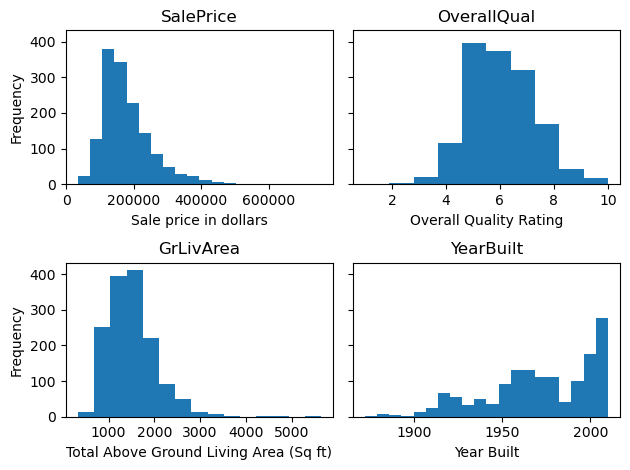

In [11]:
fig, axs = plt.subplots(2,2, sharey=True, tight_layout=True)
i=0
for col in columns_plot1:
    axs[i//2, i%2].hist(housing[col], bins=numbins[col])
    axs[i//2, i%2].set_title(col)
    axs[i//2, i%2].set_xlabel(units[col])
    i = i+1

plt.setp(axs[:, 0], ylabel='Frequency')

[Text(0, 0.5, 'Frequency'), Text(0, 0.5, 'Frequency')]

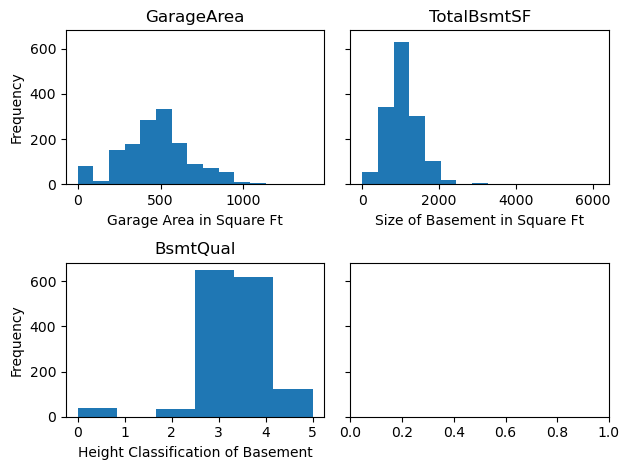

In [12]:
fig, axs = plt.subplots(2,2, sharey=True, tight_layout=True)
i=0
for col in columns_plot2:
    axs[i//2, i%2].hist(housing[col], bins=numbins[col])
    axs[i//2, i%2].set_title(col)
    axs[i//2, i%2].set_xlabel(units[col])
    i = i+1

plt.setp(axs[:, 0], ylabel='Frequency')

[Text(0, 0.5, 'Frequency'), Text(0, 0.5, 'Frequency')]

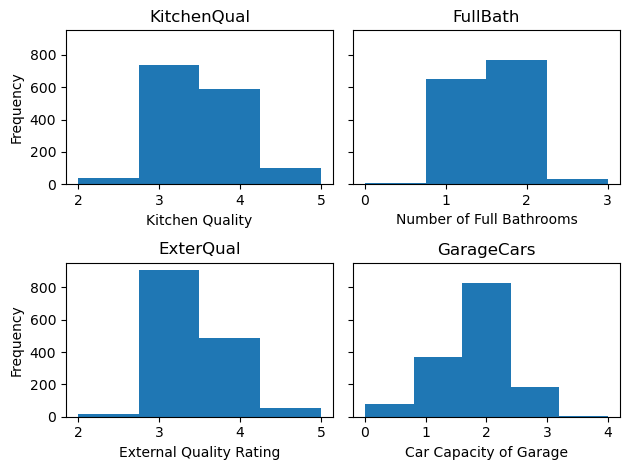

In [13]:
fig, axs = plt.subplots(2,2, sharey=True, tight_layout=True)
i=0
for col in columns_plot3:
    axs[i//2, i%2].hist(housing[col], bins=numbins[col])
    axs[i//2, i%2].set_title(col)
    axs[i//2, i%2].set_xlabel(units[col])
    i = i+1

plt.setp(axs[:, 0], ylabel='Frequency')

Most of the quality variables are normal-ish with a mean around the mid value of 3.5 (exception being BsmtQual, which has several zeros due to many houses lacking basements). Most of the area variables (and sales price) are strongly right-skewed, with most of the values falling on the left side of the graph but with several extremely large or extremely expensive properties in the tails. Including these properties in our dataset will be risky once we get to the regression part of the project, as outliers like this can strongly distort MSE values and have a strong impact on the model. Lastly, garage car capacity and number of bathrooms are normalish, centered around means of 2 and 1.5, respectively.

Now, let us summarize each of these variables

In [14]:
# needed for quartiles in agg function
def percentile(n):
    def percentile_(x):
        return x.quantile(n)
    percentile_.__name__ = '{:02.0f}%'.format(n*100)
    return percentile_

In [15]:
housing[columns].agg(["count", "mean", "std", "var", percentile(0.25), "median", percentile(0.75), "max", "skew"])

,SalePrice,OverallQual,GrLivArea,ExterQual,KitchenQual,GarageCars,GarageArea,TotalBsmtSF,YearBuilt,BsmtQual,FullBath
count,1.460000e+03,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,1.809212e+05,6.099315,1515.463699,3.395890,3.511644,1.767123,472.980137,1057.429452,1971.267808,3.489041,1.565068
std,7.944250e+04,1.382997,525.480383,0.574280,0.663760,0.747315,213.804841,438.705324,30.202904,0.876478,0.550916
var,6.311111e+09,1.912679,276129.633363,0.329798,0.440577,0.558480,45712.510229,192462.361709,912.215413,0.768214,0.303508
25%,1.299750e+05,5.000000,1129.500000,3.000000,3.000000,1.000000,334.500000,795.750000,1954.000000,3.000000,1.000000
median,1.630000e+05,6.000000,1464.000000,3.000000,3.000000,2.000000,480.000000,991.500000,1973.000000,4.000000,2.000000
75%,2.140000e+05,7.000000,1776.750000,4.000000,4.000000,2.000000,576.000000,1298.250000,2000.000000,4.000000,2.000000
max,7.550000e+05,10.000000,5642.000000,5.000000,5.000000,4.000000,1418.000000,6110.000000,2010.000000,5.000000,3.000000
skew,1.882876e+00,0.216944,1.366560,0.825988,0.386765,-0.342549,0.179981,1.524255,-0.613461,-1.287571,0.036562


Indeed, this confirms our earlier comments about the distribution of the variables. Most of the quality variables are normal-ish with a mean around the mid value of 3.5 (or 6 in the case of overall quality), with a median relatively near to the mean (i.e. relatively little skew). The exception is BsmtQual, which due to the zeros from houses with missing basements, is strongly left-skewed. As mentioned, for all the area variables and sales price, we see a strong right-skew, which is confirmed by the fact that the median for these variables is below the mean (large outliers pull the mean upwards). For instance, the median home price is \\$163k, but the mean is \\$181k.

Lastly, although we didn't comment on the graph earlier, YearBuilt shows a upward trend over time, with most homes being built recently, i.e. since the year 2000. Interestingly, there seem to be waves of home building in the town's history, with a small peak during the 20s (the town apparently experienced rapid growth during this period), another after the war, and then the recent housing boom. This results in a strong left skew, as most houses were built recently, but there are long tails going back more than 100 years.

Now, to look at the difference in a single variable between two scenarios, it is best to use some kind of categorical variable, in this instance neighbourhood seems like a good option for the comparison. First, let us look at the neighborhoods by number of properties.

In [16]:
listNBH = housing.groupby("Neighborhood").count()["SalePrice"].sort_values(ascending=False)
listNBH

Neighborhood
NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
Timber      38
IDOTRR      37
ClearCr     28
StoneBr     25
SWISU       25
Blmngtn     17
MeadowV     17
BrDale      16
Veenker     11
NPkVill      9
Blueste      2
Name: SalePrice, dtype: int64

Ok, let us compare a few of these:

In [17]:
NBH1 = listNBH[0:4]
NBH2 = listNBH[5:9]
NBH3 = listNBH[10:14]

[Text(0, 0.5, 'Frequency'), Text(0, 0.5, 'Frequency')]

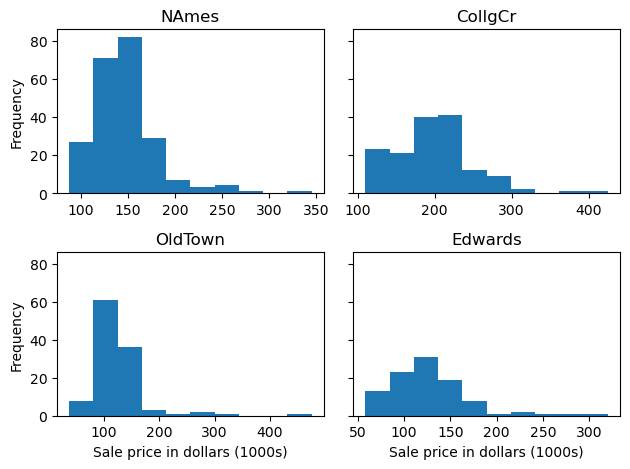

In [18]:
fig, axs = plt.subplots(2,2, sharey=True, tight_layout=True)
i=0
for neighborhood in NBH1.index:
    axs[i//2, i%2].hist(housing[housing.Neighborhood==neighborhood]["SalePrice"]/1000)
    axs[i//2, i%2].set_title(neighborhood)
    i = i+1

plt.setp(axs[-1], xlabel="Sale price in dollars (1000s)") 
plt.setp(axs[:, 0], ylabel='Frequency')

[Text(0, 0.5, 'Frequency'), Text(0, 0.5, 'Frequency')]

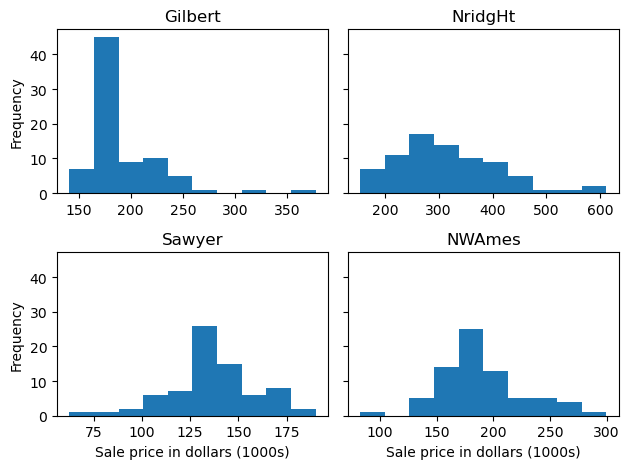

In [19]:
fig, axs = plt.subplots(2,2, sharey=True, tight_layout=True)
i=0
for neighborhood in NBH2.index:
    axs[i//2, i%2].hist(housing[housing.Neighborhood==neighborhood]["SalePrice"]/1000)
    axs[i//2, i%2].set_title(neighborhood)
    i = i+1

plt.setp(axs[-1], xlabel="Sale price in dollars (1000s)") 
plt.setp(axs[:, 0], ylabel='Frequency')

[Text(0, 0.5, 'Frequency'), Text(0, 0.5, 'Frequency')]

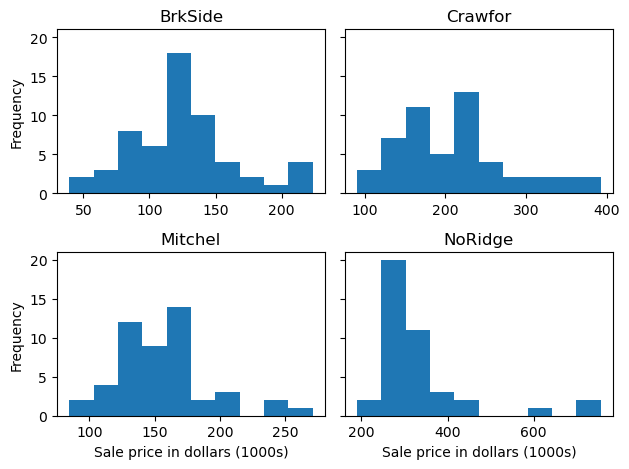

In [20]:
fig, axs = plt.subplots(2,2, sharey=True, tight_layout=True)
i=0
for neighborhood in NBH3.index:
    axs[i//2, i%2].hist(housing[housing.Neighborhood==neighborhood]["SalePrice"]/1000)
    axs[i//2, i%2].set_title(neighborhood)
    i = i+1

plt.setp(axs[-1], xlabel="Sale price in dollars (1000s)") 
plt.setp(axs[:, 0], ylabel='Frequency')

While we see some interesting patterns here, there is not really a good test we can cook up using this variable here. Of course different neighborhoods have different distributions and sales prices, but that could be for many different reasons, such as the houses in one neighborhood generally being larger than the houses in another neighborhood. Also note that many neighborhoods exhibit the strong left skew we see in the overall housing prices (i.e. prices bunched to the left, with several valuable outliers to the right), which others (such as BrkSide) are more normal. In any case, a better estimate of the true value of a neighborhood is price per square foot, so let us compare this for the different neighborhoods.

In [21]:
housing_HT = housing
housing_HT["PricePSqFt"] = housing_HT["SalePrice"]/housing_HT["GrLivArea"]
housing_HT.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,PricePSqFt
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2008,WD,Normal,208500,121.929825
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,5,2007,WD,Normal,181500,143.819334
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,9,2008,WD,Normal,223500,125.139978
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000,81.537566
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,12,2008,WD,Normal,250000,113.739763


Ok, let us compare the same, but for this new computed field which is a better assessment of neighborhood value

[Text(0, 0.5, 'Frequency'), Text(0, 0.5, 'Frequency')]

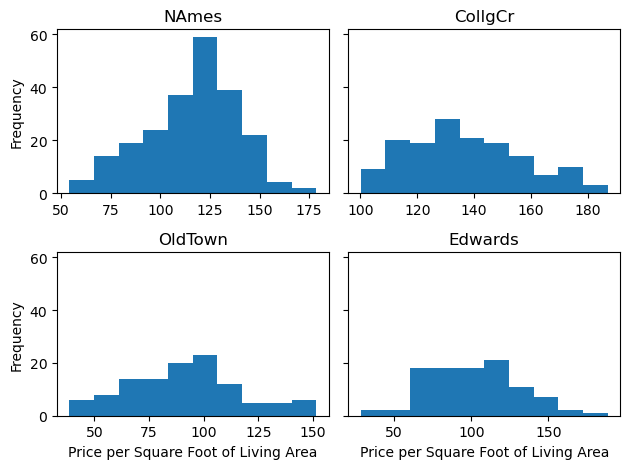

In [22]:
fig, axs = plt.subplots(2,2, sharey=True, tight_layout=True)
i=0
for neighborhood in NBH1.index:
    axs[i//2, i%2].hist(housing_HT[housing_HT.Neighborhood==neighborhood]["PricePSqFt"])
    axs[i//2, i%2].set_title(neighborhood)
    i = i+1

plt.setp(axs[-1], xlabel="Price per Square Foot of Living Area") 
plt.setp(axs[:, 0], ylabel='Frequency')

[Text(0, 0.5, 'Frequency'), Text(0, 0.5, 'Frequency')]

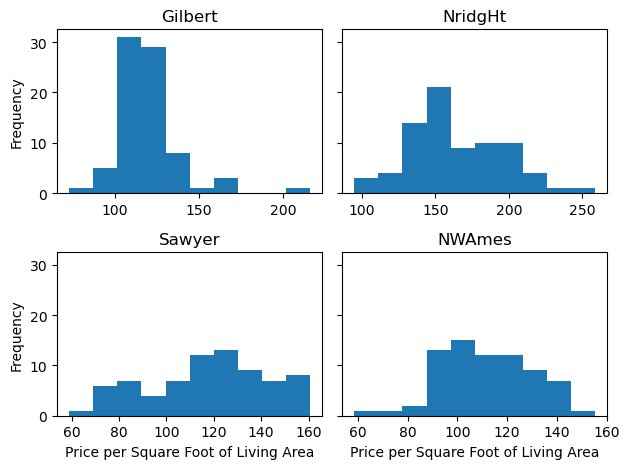

In [23]:
fig, axs = plt.subplots(2,2, sharey=True, tight_layout=True)
i=0
for neighborhood in NBH2.index:
    axs[i//2, i%2].hist(housing_HT[housing_HT.Neighborhood==neighborhood]["PricePSqFt"])
    axs[i//2, i%2].set_title(neighborhood)
    i = i+1

plt.setp(axs[-1], xlabel="Price per Square Foot of Living Area") 
plt.setp(axs[:, 0], ylabel='Frequency')

[Text(0, 0.5, 'Frequency'), Text(0, 0.5, 'Frequency')]

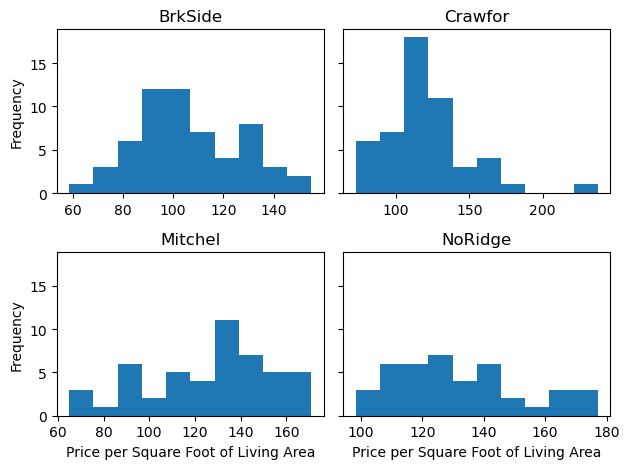

In [24]:
fig, axs = plt.subplots(2,2, sharey=True, tight_layout=True)
i=0
for neighborhood in NBH3.index:
    axs[i//2, i%2].hist(housing_HT[housing_HT.Neighborhood==neighborhood]["PricePSqFt"])
    axs[i//2, i%2].set_title(neighborhood)
    i = i+1

plt.setp(axs[-1], xlabel="Price per Square Foot of Living Area") 
plt.setp(axs[:, 0], ylabel='Frequency')

Indeed, under this transformation, the values of homes are a) more normal for most neighborhoods, and b) more comparable between neighborhoods. We will to test if neighborhood can have a statistically significant impact on home values, but we need to determine whether the data is normal

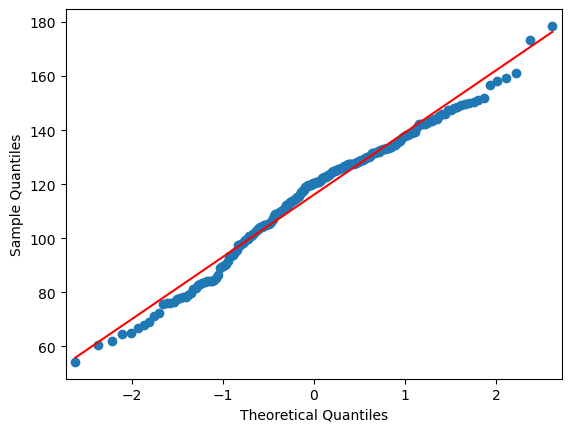

In [25]:
sm.qqplot(housing_HT[housing_HT["Neighborhood"]=="NAmes"].PricePSqFt, line="s")
plt.show()

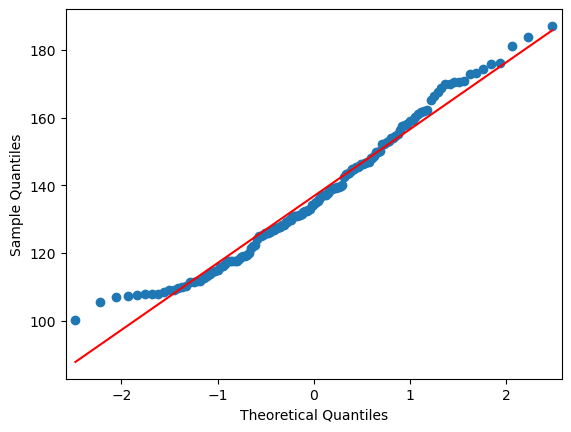

In [26]:
sm.qqplot(housing_HT[housing_HT["Neighborhood"]=="CollgCr"].PricePSqFt, line="s")
plt.show()

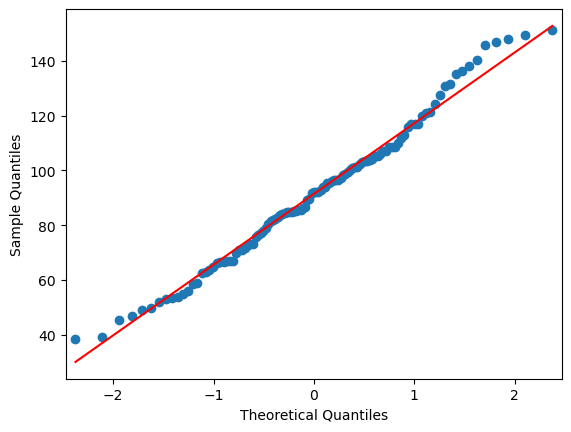

In [27]:
sm.qqplot(housing_HT[housing_HT["Neighborhood"]=="OldTown"].PricePSqFt, line="s")
plt.show()

Indeed, for most neighborhoods with sufficient sizes, the distribution of values appears fairly normal, but we must test this definitively with the Shapiro-Wilk test

In [28]:
print("Neighborhood \t\t p-value")
for neighborhood in listNBH.index:
    test_result = shapiro(housing_HT[housing_HT["Neighborhood"]==neighborhood]["PricePSqFt"])
    print("{}\t\t {}".format(neighborhood, test_result[1]))

Neighborhood 		 p-value
NAmes		 0.00391990696589368
CollgCr		 0.003127287379455554
OldTown		 0.2210613102902212
Edwards		 0.43371944015091146
Somerst		 0.03070507654396703
Gilbert		 1.7707389731709016e-07
NridgHt		 0.3175209066499842
Sawyer		 0.07643369845275176
NWAmes		 0.767609425419731
SawyerW		 0.46890037661318956
BrkSide		 0.11083012258887714
Crawfor		 0.0009757848029395621
Mitchel		 0.06681233147157349
NoRidge		 0.08740651578947886
Timber		 0.05699164310065041
IDOTRR		 0.7691246085861111
ClearCr		 0.048816786822595486
StoneBr		 0.04005276524212258
SWISU		 0.0348589451529409
Blmngtn		 0.7141046733668631
MeadowV		 0.10448550822147884
BrDale		 0.3524619320493624
Veenker		 0.40030647829614596
NPkVill		 0.12896285631502358


ValueError: Data must be at least length 3.

Note that data can only be said to be normal if we fail to reject the null hypothesis of the Shapiro-Wilk test, which isn't the case for all the neighborhoods above, in particular for North Ames and for College Center. For these we will need to use the book's nonparametric test. As for others, such as Old Town and Edwards, they are indeed normal, so we can perform a parametric hypothesis test to see if their means are significantly different. To know which test we need to perform, we need to look at the variance of each group:

In [29]:
listNBH2 = housing_HT[["Neighborhood", "PricePSqFt"]].groupby("Neighborhood").agg(["mean", "var"])
listNBH2

PricePSqFt             
                    mean          var
Neighborhood                         
Blmngtn       136.566974   270.350162
Blueste        98.969369     7.416390
BrDale         91.950543   118.931480
BrkSide       105.966809   439.195677
ClearCr       124.242989  1235.860223
CollgCr       136.783680   394.261990
Crawfor       120.254826   876.284512
Edwards       101.832958   815.839672
Gilbert       119.114931   370.238626
IDOTRR         89.136043   754.412331
MeadowV       101.926201   783.257152
Mitchel       126.017449   777.573293
NAmes         116.089385   532.884900
NPkVill       116.726891   323.208448
NWAmes        111.848349   338.239668
NoRidge       132.271687   474.378139
NridgHt       164.578057   995.110679
OldTown        91.427282   675.117452
SWISU          84.755233   464.770459
Sawyer        117.856163   652.964586
SawyerW       119.704424   489.035684
Somerst       141.335966   587.958948
StoneBr       165.402275  1290.422694
Timber        139.766483   836.060418
Veenker       154.980914  1066.771815

Their variance is quite different, 816 for Edwards and 675 for Old Town, so we will need an unpaired t-test (a.k.a. Welch's t-test), it will be 2-sided because the difference in means could go either way:

In [30]:
ttest_ind(a=housing_HT[housing_HT["Neighborhood"]=="OldTown"].PricePSqFt, b=housing_HT[housing_HT["Neighborhood"]=="Edwards"].PricePSqFt, equal_var=False)

TtestResult(statistic=-2.7679284291723474, pvalue=0.006167067236699262, df=201.54865821127666)

With a p-value of 0.006, we would reject the null hypothesis (even at alpha=0.01) and conclude the two neighborhoods have definitively different price per square foot values, notable Old Town being about \\$10 per square foot cheaper than Edwards on average.

Now let us try the book's non-parametric test on a couple of the non-normal groups, to see if we get a similar result:

In [31]:
data = housing_HT[housing_HT["Neighborhood"]=="NAmes"].PricePSqFt, housing_HT[housing_HT["Neighborhood"]=="CollgCr"].PricePSqFt
ht = hypothesis.DiffMeansPermute(data)
pvalue = ht.PValue()
pvalue

0.0

In other words, exactly zero of the random permutations of the pooled data, when parcelled out into similarly sized groups at random, showed as great or greater of a group mean difference of that which we see in the real data. This is perhaps unsurprising since in the original data, the two groups show a \\$20 per square foot different in housing price per square foot. This confirms that the difference is likely significant. With this in mind, we have decided to eventually include Neighborhood in our regression model.

Now, the distribution of our target variable itself, as we have discussed, appears decidedly not normal:

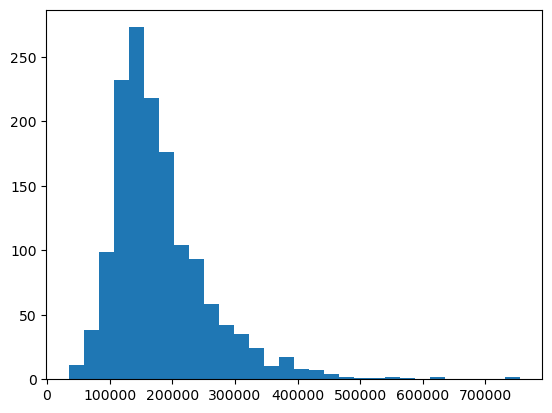

In [32]:
plt.hist(housing["SalePrice"], bins=30)
plt.show()

This is confirmed by its cdf:

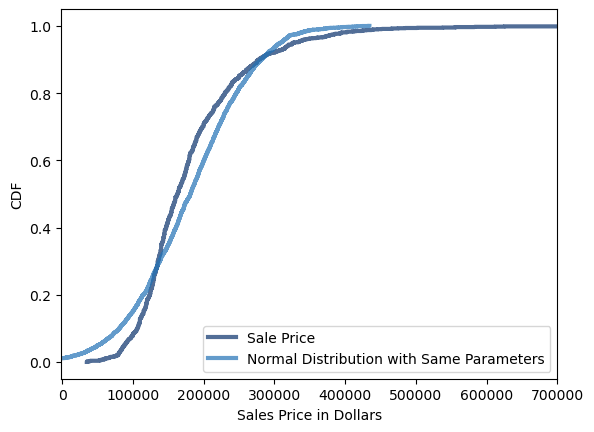

<Figure size 800x600 with 0 Axes>

In [33]:
s = np.random.normal(housing.SalePrice.mean(), housing.SalePrice.std(), 3000)
cdf = thinkstats2.Cdf(housing["SalePrice"], label="Sale Price")
cdf2 = thinkstats2.Cdf(s, label="Normal Distribution with Same Parameters")
thinkplot.Cdf(cdf)
thinkplot.Cdf(cdf2)
thinkplot.Show(xlabel="Sales Price in Dollars", ylabel="CDF", xlim=[-1000, 700000])

As is clearly seen, the sale price is not normal, but rather increases quickly, surpassing the normal distribution, then passes below it again, as it has very long tails and it takes a while to reach the last few values. Now, one way to tame these outliers may be to take log of sales price. Let us test to see if it is log-normal perhaps:

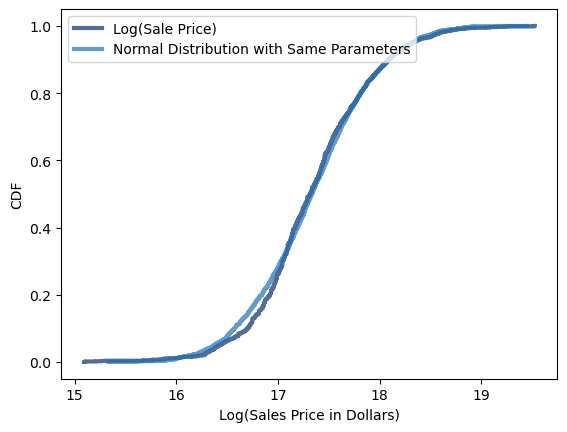

<Figure size 800x600 with 0 Axes>

In [34]:
s = np.random.normal(np.log2(housing.SalePrice).mean(), np.log2(housing.SalePrice).std(), 3000)
cdf = thinkstats2.Cdf(np.log2(housing["SalePrice"]), label="Log(Sale Price)")
cdf2 = thinkstats2.Cdf(s, label="Normal Distribution with Same Parameters")
thinkplot.Cdf(cdf)
thinkplot.Cdf(cdf2)
thinkplot.Show(xlabel="Log(Sales Price in Dollars)", ylabel="CDF")

Indeed, it appears to be log-normal. This is sort of irrelevent for our regression model, except for the fact that it might be a better target variable to build our model on since there are fewer outliers.

Alright, now let us compare all our numerical variables to each other and look for correlations between them:

In [35]:
columns1 = ["OverallQual", "GrLivArea", "ExterQual", "KitchenQual", "GarageCars", "SalePrice"]
columns2 = ["GarageArea", "TotalBsmtSF", "YearBuilt", "BsmtQual", "FullBath", "SalePrice"]

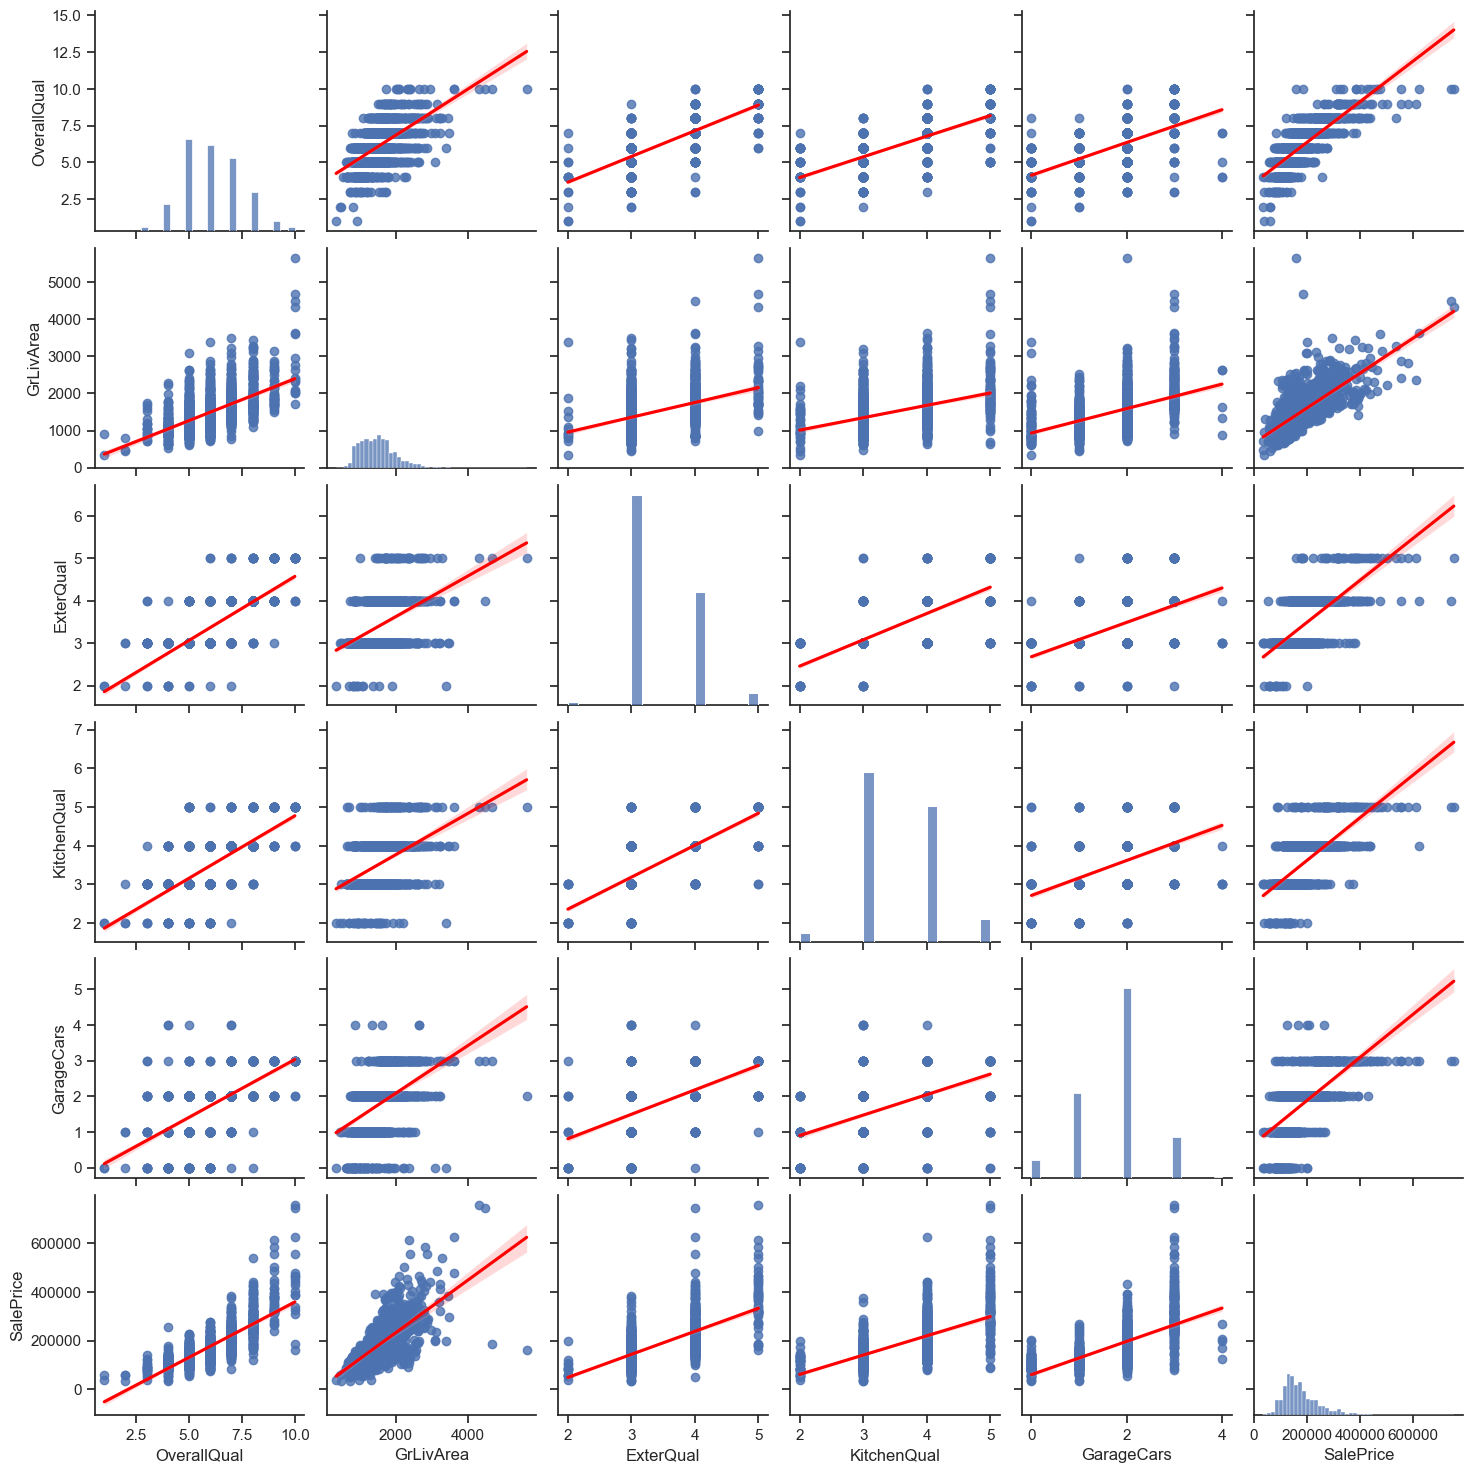

In [36]:
sns.set(style="ticks", color_codes=True)
g = sns.pairplot(housing[columns1], kind="reg", plot_kws={'line_kws':{'color':'red'}})
plt.show()

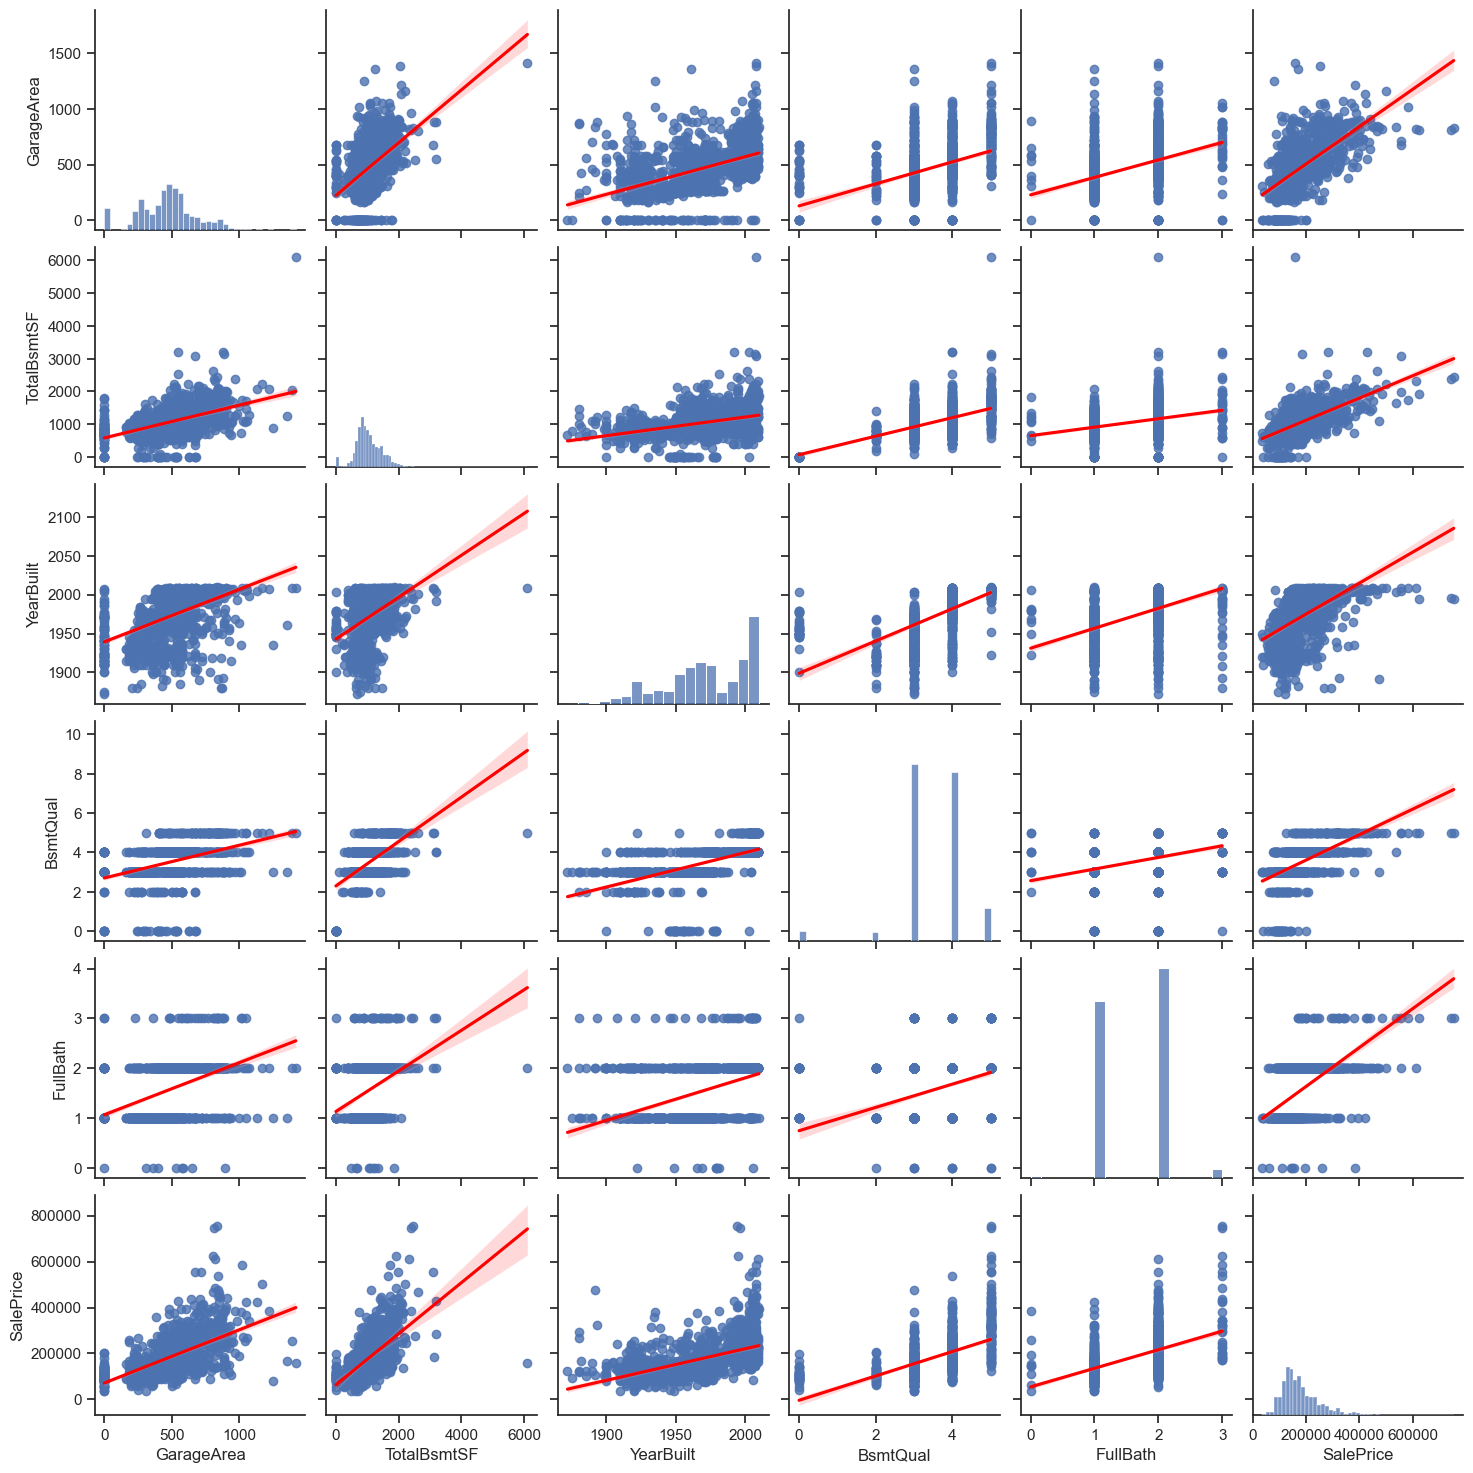

In [37]:
sns.set(style="ticks", color_codes=True)
g = sns.pairplot(housing[columns2], kind="reg", plot_kws={'line_kws':{'color':'red'}})
plt.show()

As might be expected, all variables related to area and quality have a positive correlation with sales price. This correlation appears to be particularly tight with overall quality. Additionally, year built has a positive correlation, with newer houses generally being worth more. Let us check these correlations explicitly:

In [38]:
housing_corr = housing[columns]

In [39]:
housing_corr.corr()

,SalePrice,OverallQual,GrLivArea,ExterQual,KitchenQual,GarageCars,GarageArea,TotalBsmtSF,YearBuilt,BsmtQual,FullBath
SalePrice,1.000000,0.790982,0.708624,0.682639,0.659600,0.640409,0.623431,0.613581,0.522897,0.585207,0.560664
OverallQual,0.790982,1.000000,0.593007,0.726278,0.673331,0.600671,0.562022,0.537808,0.572323,0.629379,0.550600
GrLivArea,0.708624,0.593007,1.000000,0.435986,0.420563,0.467247,0.468997,0.454868,0.199010,0.327956,0.630012
ExterQual,0.682639,0.726278,0.435986,1.000000,0.716122,0.526390,0.495778,0.470580,0.598160,0.565558,0.483949
KitchenQual,0.659600,0.673331,0.420563,0.716122,1.000000,0.509810,0.489606,0.432630,0.530165,0.510938,0.434648
GarageCars,0.640409,0.600671,0.467247,0.526390,0.509810,1.000000,0.882475,0.434585,0.537850,0.449194,0.469672
GarageArea,0.623431,0.562022,0.468997,0.495778,0.489606,0.882475,1.000000,0.486665,0.478954,0.406109,0.405656
TotalBsmtSF,0.613581,0.537808,0.454868,0.470580,0.432630,0.434585,0.486665,1.000000,0.391452,0.564299,0.323722
YearBuilt,0.522897,0.572323,0.199010,0.598160,0.530165,0.537850,0.478954,0.391452,1.000000,0.602797,0.468271
BsmtQual,0.585207,0.629379,0.327956,0.565558,0.510938,0.449194,0.406109,0.564299,0.602797,1.000000,0.371243


Some of these features, especially OverallQual, will be quite useful in a linear model for SalePrice. Let us see if log(SalePrice) has stronger correlations:

In [40]:
housing_log = housing_corr
housing_log["SalePrice"] = np.log2(housing_log.SalePrice)

C:\Users\17324\AppData\Local\Temp\ipykernel_22788\269322573.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  housing_log["SalePrice"] = np.log2(housing_log.SalePrice)


In [41]:
housing_log.corr()

,SalePrice,OverallQual,GrLivArea,ExterQual,KitchenQual,GarageCars,GarageArea,TotalBsmtSF,YearBuilt,BsmtQual,FullBath
SalePrice,1.000000,0.817184,0.700927,0.678840,0.667893,0.680625,0.650888,0.612134,0.586570,0.615804,0.594771
OverallQual,0.817184,1.000000,0.593007,0.726278,0.673331,0.600671,0.562022,0.537808,0.572323,0.629379,0.550600
GrLivArea,0.700927,0.593007,1.000000,0.435986,0.420563,0.467247,0.468997,0.454868,0.199010,0.327956,0.630012
ExterQual,0.678840,0.726278,0.435986,1.000000,0.716122,0.526390,0.495778,0.470580,0.598160,0.565558,0.483949
KitchenQual,0.667893,0.673331,0.420563,0.716122,1.000000,0.509810,0.489606,0.432630,0.530165,0.510938,0.434648
GarageCars,0.680625,0.600671,0.467247,0.526390,0.509810,1.000000,0.882475,0.434585,0.537850,0.449194,0.469672
GarageArea,0.650888,0.562022,0.468997,0.495778,0.489606,0.882475,1.000000,0.486665,0.478954,0.406109,0.405656
TotalBsmtSF,0.612134,0.537808,0.454868,0.470580,0.432630,0.434585,0.486665,1.000000,0.391452,0.564299,0.323722
YearBuilt,0.586570,0.572323,0.199010,0.598160,0.530165,0.537850,0.478954,0.391452,1.000000,0.602797,0.468271
BsmtQual,0.615804,0.629379,0.327956,0.565558,0.510938,0.449194,0.406109,0.564299,0.602797,1.000000,0.371243


Only a marginal improvement. For now we will leave sale price unchanged. Now let us try to build a model with the columns we have selected:

In [42]:
columns_final = ["OverallQual", "GrLivArea", "ExterQual", "KitchenQual", "GarageCars", "GarageArea", "TotalBsmtSF", "YearBuilt", "BsmtQual", "FullBath", "Neighborhood"]
all_columns = "+".join(columns_final)
formula = "SalePrice ~ " + all_columns

In [43]:
results = smf.ols(formula, data=housing).fit()

In [44]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     190.2
Date:                Sun, 11 Aug 2024   Prob (F-statistic):               0.00
Time:                        06:46:10   Log-Likelihood:                -17295.
No. Observations:                1460   AIC:                         3.466e+04
Df Residuals:                    1425   BIC:                         3.484e+04
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept               -3.157e+05   1.38e+05     -2.280      0.023   -5.87e+05   -4.41e+04
Neighborhood[T.Blueste] -2042.0015   2.57e+04     -0.079      0.937   -5.25e+04    4.85e+04
Neighborhood[T.BrDale]  -4601.3604   1.24e+04     -0.371      0.711   -2.89e+04    1.97e+04
Neighborhood[T.BrkSide]  2.213e+04   1.07e+04      2.073      0.038    1188.190    4.31e+04
Neighborhood[T.ClearCr]  4.185e+04    1.1e+04      3.801      0.000    2.03e+04    6.34e+04
Neighborhood[T.CollgCr]  1.797e+04   8900.174      2.019      0.044     513.168    3.54e+04
Neighborhood[T.Crawfor]  4.381e+04   1.05e+04      4.172      0.000    2.32e+04    6.44e+04
Neighborhood[T.Edwards]  1.006e+04   9756.330      1.031      0.303   -9079.033    2.92e+04
Neighborhood[T.Gilbert]  1.761e+04   9325.001      1.888      0.059    -682.545    3.59e+04
Neighborhood[T.IDOTRR]   6421.7752   1.14e+04      0.564      0.573   -1.59e+04    2.88e+04
Neighborhood[T.MeadowV]  3713.7186   1.24e+04      0.300      0.764   -2.06e+04     2.8e+04
Neighborhood[T.Mitchel]   1.81e+04   9998.004      1.810      0.070   -1515.029    3.77e+04
Neighborhood[T.NAmes]    1.866e+04   9353.028      1.995      0.046     310.697     3.7e+04
Neighborhood[T.NPkVill]  5576.7427   1.44e+04      0.388      0.698   -2.26e+04    3.38e+04
Neighborhood[T.NWAmes]   1.634e+04   9624.978      1.698      0.090   -2541.887    3.52e+04
Neighborhood[T.NoRidge]  7.321e+04   1.02e+04      7.173      0.000    5.32e+04    9.32e+04
Neighborhood[T.NridgHt]  6.389e+04   9355.757      6.829      0.000    4.55e+04    8.22e+04
Neighborhood[T.OldTown]  1784.5984   1.04e+04      0.171      0.864   -1.87e+04    2.22e+04
Neighborhood[T.SWISU]    5786.0329   1.21e+04      0.478      0.632   -1.79e+04    2.95e+04
Neighborhood[T.Sawyer]   2.039e+04   9857.738      2.069      0.039    1055.722    3.97e+04
Neighborhood[T.SawyerW]  1.475e+04   9610.039      1.535      0.125   -4098.507    3.36e+04
Neighborhood[T.Somerst]  2.301e+04   9229.059      2.494      0.013    4910.969    4.11e+04
Neighborhood[T.StoneBr]  7.135e+04   1.09e+04      6.570      0.000       5e+04    9.27e+04
Neighborhood[T.Timber]   3.587e+04   1.01e+04      3.550      0.000     1.6e+04    5.57e+04
Neighborhood[T.Veenker]  5.326e+04   1.34e+04      3.978      0.000     2.7e+04    7.95e+04
OverallQual              1.179e+04   1254.869      9.393      0.000    9324.869    1.42e+04
GrLivArea                  47.4939      2.894     16.409      0.000      41.816      53.172
ExterQual                7346.5643   2781.225      2.641      0.008    1890.830    1.28e+04
KitchenQual              1.338e+04   2103.332      6.361      0.000    9252.467    1.75e+04
GarageCars               8269.9655   2869.284      2.882      0.004    2641.491    1.39e+04
GarageArea                 13.3227      9.748  

R-squared of 0.819, which is not a bad result. Our model explains nearly 82\\% of the variance in the data. Full Bath, Garage Area, and Year Built appear to have a weak, statistically insignificant relationship, so let us remove them and repeat:

In [45]:
columns_final = ["OverallQual", "GrLivArea", "ExterQual", "KitchenQual", "GarageCars", "TotalBsmtSF", "BsmtQual", "Neighborhood"]
all_columns = "+".join(columns_final)
formula = "SalePrice ~ " + all_columns

In [46]:
results = smf.ols(formula, data=housing).fit()

In [47]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     208.2
Date:                Sun, 11 Aug 2024   Prob (F-statistic):               0.00
Time:                        06:46:10   Log-Likelihood:                -17297.
No. Observations:                1460   AIC:                         3.466e+04
Df Residuals:                    1428   BIC:                         3.483e+04
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept               -1.169e+05   1.31e+04     -8.890      0.000   -1.43e+05   -9.11e+04
Neighborhood[T.Blueste] -1871.4553   2.57e+04     -0.073      0.942   -5.23e+04    4.86e+04
Neighborhood[T.BrDale]  -3940.0759   1.23e+04     -0.321      0.748    -2.8e+04    2.01e+04
Neighborhood[T.BrkSide]   1.89e+04   9902.186      1.909      0.056    -523.383    3.83e+04
Neighborhood[T.ClearCr]  4.129e+04   1.08e+04      3.818      0.000    2.01e+04    6.25e+04
Neighborhood[T.CollgCr]  1.981e+04   8798.942      2.252      0.024    2553.367    3.71e+04
Neighborhood[T.Crawfor]  4.067e+04   9878.078      4.117      0.000    2.13e+04       6e+04
Neighborhood[T.Edwards]  9133.0463   9441.121      0.967      0.334   -9386.908    2.77e+04
Neighborhood[T.Gilbert]  1.825e+04   9322.021      1.958      0.050     -32.220    3.65e+04
Neighborhood[T.IDOTRR]   3695.1233   1.05e+04      0.350      0.726    -1.7e+04    2.44e+04
Neighborhood[T.MeadowV]  4856.2585   1.22e+04      0.397      0.691   -1.91e+04    2.88e+04
Neighborhood[T.Mitchel]  1.909e+04   9890.389      1.930      0.054    -314.539    3.85e+04
Neighborhood[T.NAmes]    1.834e+04   9004.699      2.037      0.042     680.873     3.6e+04
Neighborhood[T.NPkVill]  3854.7978   1.43e+04      0.270      0.787   -2.42e+04    3.19e+04
Neighborhood[T.NWAmes]    1.62e+04   9498.578      1.706      0.088   -2428.448    3.48e+04
Neighborhood[T.NoRidge]  7.465e+04   1.01e+04      7.372      0.000    5.48e+04    9.45e+04
Neighborhood[T.NridgHt]  6.561e+04   9242.526      7.099      0.000    4.75e+04    8.37e+04
Neighborhood[T.OldTown] -2430.3193   9362.933     -0.260      0.795   -2.08e+04    1.59e+04
Neighborhood[T.SWISU]    1840.8113   1.13e+04      0.162      0.871   -2.04e+04    2.41e+04
Neighborhood[T.Sawyer]   2.024e+04   9601.211      2.108      0.035    1408.524    3.91e+04
Neighborhood[T.SawyerW]  1.573e+04   9543.241      1.648      0.100   -2993.498    3.44e+04
Neighborhood[T.Somerst]   2.52e+04   9107.437      2.767      0.006    7338.286    4.31e+04
Neighborhood[T.StoneBr]  7.217e+04   1.08e+04      6.680      0.000     5.1e+04    9.34e+04
Neighborhood[T.Timber]   3.661e+04      1e+04      3.648      0.000    1.69e+04    5.63e+04
Neighborhood[T.Veenker]  5.371e+04   1.33e+04      4.051      0.000    2.77e+04    7.97e+04
OverallQual               1.19e+04   1251.951      9.507      0.000    9446.203    1.44e+04
GrLivArea                  46.2146      2.435     18.976      0.000      41.437      50.992
ExterQual                7647.9381   2763.515      2.767      0.006    2226.954    1.31e+04
KitchenQual              1.372e+04   2095.633      6.546      0.000    9606.534    1.78e+04
GarageCars               1.182e+04   1670.257      7.075      0.000    8541.108    1.51e+04
TotalBsmtSF                18.8157      2.905  

So we get the same R-squared, but with fewer features, a decent result. Let's see if we get any better results with log(SalePrice):

In [48]:
columns = ["SalePrice", "OverallQual", "GrLivArea", "ExterQual", "KitchenQual", "GarageCars", "GarageArea", "TotalBsmtSF", "YearBuilt", "BsmtQual", "FullBath", "Neighborhood"]
housing_log = housing[columns]
housing_log["SalePrice"] = np.log2(housing_log.SalePrice)

C:\Users\17324\AppData\Local\Temp\ipykernel_22788\3887473474.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  housing_log["SalePrice"] = np.log2(housing_log.SalePrice)


In [49]:
columns_final = ["OverallQual", "GrLivArea", "ExterQual", "KitchenQual", "GarageCars", "GarageArea", "TotalBsmtSF", "YearBuilt", "BsmtQual", "FullBath", "Neighborhood"]
all_columns = "+".join(columns_final)
formula = "SalePrice ~ " + all_columns

In [50]:
results = smf.ols(formula, data=housing_log).fit()

In [51]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.854
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     245.8
Date:                Sun, 11 Aug 2024   Prob (F-statistic):               0.00
Time:                        06:46:10   Log-Likelihood:                 139.82
No. Observations:                1460   AIC:                            -209.6
Df Residuals:                    1425   BIC:                            -24.63
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  12.3977      0.902     13.746      0.000      10.628      14.167
Neighborhood[T.Blueste]    -0.1118      0.168     -0.666      0.505      -0.441       0.217
Neighborhood[T.BrDale]     -0.2495      0.081     -3.088      0.002      -0.408      -0.091
Neighborhood[T.BrkSide]     0.0420      0.070      0.603      0.546      -0.094       0.178
Neighborhood[T.ClearCr]     0.3288      0.072      4.585      0.000       0.188       0.470
Neighborhood[T.CollgCr]     0.1056      0.058      1.822      0.069      -0.008       0.219
Neighborhood[T.Crawfor]     0.3220      0.068      4.705      0.000       0.188       0.456
Neighborhood[T.Edwards]    -0.0334      0.064     -0.525      0.600      -0.158       0.091
Neighborhood[T.Gilbert]     0.1154      0.061      1.899      0.058      -0.004       0.235
Neighborhood[T.IDOTRR]     -0.2268      0.074     -3.056      0.002      -0.372      -0.081
Neighborhood[T.MeadowV]    -0.2325      0.081     -2.881      0.004      -0.391      -0.074
Neighborhood[T.Mitchel]     0.0908      0.065      1.394      0.163      -0.037       0.219
Neighborhood[T.NAmes]       0.1129      0.061      1.853      0.064      -0.007       0.232
Neighborhood[T.NPkVill]    -0.0338      0.094     -0.361      0.718      -0.218       0.150
Neighborhood[T.NWAmes]      0.1187      0.063      1.893      0.059      -0.004       0.242
Neighborhood[T.NoRidge]     0.2617      0.067      3.936      0.000       0.131       0.392
Neighborhood[T.NridgHt]     0.2281      0.061      3.743      0.000       0.109       0.348
Neighborhood[T.OldTown]    -0.0937      0.068     -1.380      0.168      -0.227       0.040
Neighborhood[T.SWISU]       0.0298      0.079      0.378      0.706      -0.125       0.184
Neighborhood[T.Sawyer]      0.1065      0.064      1.659      0.097      -0.019       0.233
Neighborhood[T.SawyerW]     0.0719      0.063      1.148      0.251      -0.051       0.195
Neighborhood[T.Somerst]     0.1162      0.060      1.933      0.053      -0.002       0.234
Neighborhood[T.StoneBr]     0.2830      0.071      3.999      0.000       0.144       0.422
Neighborhood[T.Timber]      0.1971      0.066      2.994      0.003       0.068       0.326
Neighborhood[T.Veenker]     0.3520      0.087      4.035      0.000       0.181       0.523
OverallQual                 0.1074      0.008     13.142      0.000       0.091       0.123
GrLivArea                   0.0003   1.89e-05     16.538      0.000       0.000       0.000
ExterQual                   0.0044      0.018      0.242      0.809      -0.031       0.040
KitchenQual                 0.0939      0.014      6.852      0.000       0.067       0.121
GarageCars                  0.0720      0.019      3.853      0.000       0.035       0.109
GarageArea                  0.0001   6.35e-05  

This result is already much better, with an R-squared of 0.854. Let us remove full bath and external quality and see if the model improves:

In [52]:
columns_final = ["OverallQual", "GrLivArea", "KitchenQual", "GarageCars", "GarageArea", "TotalBsmtSF", "YearBuilt", "BsmtQual", "Neighborhood"]
all_columns = "+".join(columns_final)
formula = "SalePrice ~ " + all_columns

In [53]:
results = smf.ols(formula, data=housing_log).fit()

In [54]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.854
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     261.5
Date:                Sun, 11 Aug 2024   Prob (F-statistic):               0.00
Time:                        06:46:10   Log-Likelihood:                 139.62
No. Observations:                1460   AIC:                            -213.2
Df Residuals:                    1427   BIC:                            -38.79
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  12.2958      0.887     13.866      0.000      10.556      14.035
Neighborhood[T.Blueste]    -0.1161      0.167     -0.694      0.488      -0.444       0.212
Neighborhood[T.BrDale]     -0.2551      0.080     -3.183      0.001      -0.412      -0.098
Neighborhood[T.BrkSide]     0.0380      0.069      0.550      0.583      -0.098       0.174
Neighborhood[T.ClearCr]     0.3245      0.071      4.557      0.000       0.185       0.464
Neighborhood[T.CollgCr]     0.1043      0.058      1.801      0.072      -0.009       0.218
Neighborhood[T.Crawfor]     0.3184      0.068      4.674      0.000       0.185       0.452
Neighborhood[T.Edwards]    -0.0368      0.063     -0.582      0.561      -0.161       0.087
Neighborhood[T.Gilbert]     0.1144      0.061      1.887      0.059      -0.005       0.233
Neighborhood[T.IDOTRR]     -0.2308      0.074     -3.125      0.002      -0.376      -0.086
Neighborhood[T.MeadowV]    -0.2374      0.080     -2.960      0.003      -0.395      -0.080
Neighborhood[T.Mitchel]     0.0868      0.065      1.345      0.179      -0.040       0.213
Neighborhood[T.NAmes]       0.1078      0.060      1.788      0.074      -0.010       0.226
Neighborhood[T.NPkVill]    -0.0328      0.093     -0.353      0.724      -0.215       0.150
Neighborhood[T.NWAmes]      0.1164      0.062      1.875      0.061      -0.005       0.238
Neighborhood[T.NoRidge]     0.2585      0.066      3.902      0.000       0.129       0.388
Neighborhood[T.NridgHt]     0.2282      0.061      3.746      0.000       0.109       0.348
Neighborhood[T.OldTown]    -0.0967      0.068     -1.430      0.153      -0.229       0.036
Neighborhood[T.SWISU]       0.0279      0.079      0.355      0.723      -0.126       0.182
Neighborhood[T.Sawyer]      0.1015      0.064      1.596      0.111      -0.023       0.226
Neighborhood[T.SawyerW]     0.0696      0.062      1.114      0.265      -0.053       0.192
Neighborhood[T.Somerst]     0.1166      0.060      1.941      0.052      -0.001       0.235
Neighborhood[T.StoneBr]     0.2816      0.071      3.984      0.000       0.143       0.420
Neighborhood[T.Timber]      0.1955      0.066      2.977      0.003       0.067       0.324
Neighborhood[T.Veenker]     0.3475      0.087      3.999      0.000       0.177       0.518
OverallQual                 0.1079      0.008     13.561      0.000       0.092       0.124
GrLivArea                   0.0003   1.62e-05     19.625      0.000       0.000       0.000
KitchenQual                 0.0950      0.013      7.358      0.000       0.070       0.120
GarageCars                  0.0729      0.019      3.916      0.000       0.036       0.109
GarageArea                  0.0001   6.32e-05      2.061      0.039    6.28e-06       0.000
TotalBsmtSF              9.215e-05   1.92e-05  

Ok, same performance, but using a simpler model. We consider this a moderate success.